Simple DNN with combined (code and processed features)

In [9]:
import ktrain
import pandas as pd
from ktrain import tabular
import numpy as np
import pandas   as pd
from sklearn.utils import shuffle
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [10]:
def get_model(a,project):
    # load the model
    df = pd.read_csv(f'../data/{project}_combined.csv')
    # drop all rows in df
    df = df.drop(df.index)
    print(df.shape)
    for p,u in a.items():
        if p == project:
            continue
        df1 = pd.read_csv(f'../data/{p}_combined.csv')
        df = pd.concat([df,df1])
    df = df.drop(columns=['comments'],axis=1)
    # Count the number of rows in the "not_smell" class
    # not_smell_count = (df['catagory'] == 'not_smell').sum()

    # # Calculate the number of rows to drop (one-third of the count)
    # rows_to_drop = not_smell_count // 3

    # # Filter the DataFrame to exclude one-third of the "not_smell" class
    # filtered_smell = df[df['catagory'] == 'not_smeel'].sample(frac=(1/3))  # Selecting 2/3 of 'not_smell' instances
    # # print(filtered_smell.shape)
    
    # defalut_smell = df[df['catagory'] != 'not_smeel']
    # print(defalut_smell.shape)
    # df = pd.concat([filtered_smell, defalut_smell])
    
    train_df = shuffle(df)
    test_df = pd.read_csv(f'../data/{project}_combined.csv')
    test_df = test_df.drop(columns=['comments'],axis=1)
    # print(df['catagory'].value_counts())
    
    # df = df.sample(frac=1).reset_index(drop=True)
    
    # np.random.seed(42)
    # p = 0.1 # 10% for test set
    # prop = 1-p
    # temp_df = df.copy()
    # msk = np.random.rand(len(temp_df)) < prop
    # train_df = temp_df[msk]
    # test_df = temp_df[~msk]
    # print(train_df["label"].value_counts())
    # print(test_df["label"].value_counts())
    test_df['index'] = test_df.index
    train_df['index'] = train_df.index  
    return train_df, test_df

In [15]:
def get_lean(train_df,test_df):
    print(test_df.iloc[1])
    trn,val,preproc = tabular.tabular_from_df(train_df, label_columns=['catagory'], random_state=42)
    model  = tabular.tabular_classifier(name='mlp',train_data=trn,hidden_layers=[1000,1000,500],hidden_dropouts=[0.2,0.5,0.5])
    learner = ktrain.get_learner(model,train_data=trn,val_data=val,batch_size=32)
    # learner.lr_find(show_plot=True, max_epochs=5)
    data = {"get":0,"is":1,"not_LA":2,"set":3}
    learner.fit_onecycle(5e-3, 2)
    print(learner.evaluate(val, class_names=preproc.get_classes()))
    predictor = ktrain.get_predictor(learner.model, preproc)


    preds = predictor.predict(test_df, return_proba=True)
    try:
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for class_name, class_idx in data.items():
            y_true_class = (test_df['catagory'] == class_name).astype(int)
            y_score_class = preds[:, class_idx]
            fpr[class_name], tpr[class_name], _ = roc_curve(y_true_class, y_score_class)
            roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])
            
            
        # Plot ROC curve for each class
        plt.figure()
        for class_name, class_idx in data.items():
            plt.plot(fpr[class_name], tpr[class_name], label=f'ROC curve (AUC = {roc_auc[class_name]:0.2f}) for {class_name}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
        # Calculate AUC for each class

        auc_scores = []
        for class_name, class_idx in data.items():  # Iterate over each class
            y_true_class = (test_df['catagory'] == class_name).astype(int)  # Convert true labels to binary for the current class
            y_pred_class = preds[:, class_idx]  # Predicted probabilities for the current class
            
            # print(f'Class {class_name}:')
            # print('y_true_class:', y_true_class)
            # print('y_pred_class:', y_pred_class)
            
            auc_score = roc_auc_score(y_true_class, y_pred_class)  # Compute ROC AUC
            auc_scores.append(auc_score)
            # print(f'AUC for class {class_name}: {auc_score}')

        # Overall AUC can also be computed by averaging the AUC scores for each class
        overall_auc = np.mean(auc_scores)
        print(f'Overall AUC: {overall_auc}')
        # Calculate MCC for each class
        mcc_scores = []
        for class_name, class_idx in data.items():  # Iterate over each class
            y_true_class = (test_df['catagory'] == class_name).astype(int)  # True labels for the current class
            y_pred_class = np.argmax(preds, axis=1)  # Predicted labels for the current class
            
            # print(f'Class {class_name}:')
            # print('y_true_class:', y_true_class.shape)
            # print('y_pred_class:', y_pred_class.shape)
            
            # Filter y_pred_class to match the same samples as y_true_class
            y_pred_class_filtered = y_pred_class[test_df['catagory'] == class_name]
            # print(f"y_pred_class_filtered: {y_pred_class_filtered.shape}")
            mcc_score = matthews_corrcoef(y_true_class, y_pred_class)  # Compute MCC
            mcc_scores.append(mcc_score)
            print(f'MCC for class {class_name}: {mcc_score}')

        # Overall MCC can also be computed by averaging the MCC scores for each class
        overall_mcc = np.mean(mcc_scores)
        print(f'Overall MCC: {overall_mcc}')
        print(test_df.iloc[2])
        data = {"get":0,"is":1,"not_LA":2,"set":3}
        print("predict output is here")
        pred = predictor.predict(test_df[1:2])
        print(test_df.iloc[1])
        print(f"the prediction is {pred[0]} this")
        print()
        print()
        predictor.explain(test_df,row_num=1,class_id=data[pred[0]])
    except ValueError:
        print(f'ValueError {ValueError}')
    
    return predictor

In [12]:
def model_save(predictor,test_df,output_file):

    print()
    print()
    model_path = f'model/{output_file}_combined_model'
    print(model_path)
    print()
    print()
    predictor.save(model_path)
    reloaded_predictor = ktrain.load_predictor(model_path)
    reloaded_predictor.predict(test_df)[:5]

the project is buildship
(0, 8)
access_modifier                                               public
return_type                                     SignedEncryptedParts
method_name                                           getSignedParts
parameters                                                       NaN
returns                                         return signedParts; 
content            public SignedEncryptedParts getSignedParts() {...
catagory                                                      not_LA
index                                                              1
Name: 1, dtype: object
processing train: 142216 rows x 8 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
32263  0.0  0.0     1.0  0.0
9015   0.0  1.0     0.0  0.0
9841   0.0  1.0     0.0  0.0
1048   0.0  0.0     1.0  0.0
11500  1.0  0.0     0.0  0.0
processing test: 15637 rows x 8 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
9793   0.0  0.0     0.0  1.0
93574  0.0  0.0  

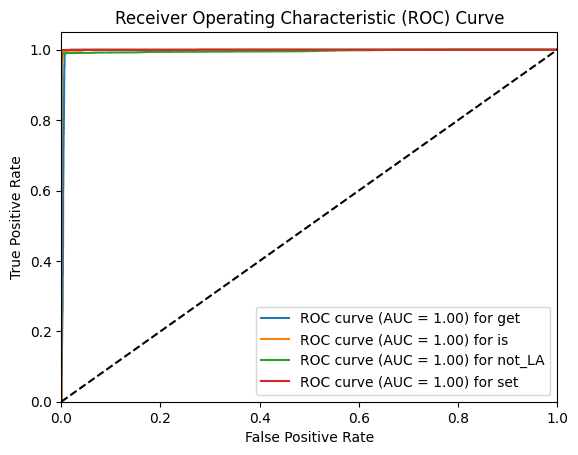

Overall AUC: 0.9980963834545908
MCC for class get: -0.4177905443671841
MCC for class is: 0.20664777212652075
MCC for class not_LA: 0.2251475061546374
MCC for class set: 0.10564222104402807
Overall MCC: 0.02991173873950053
access_modifier                                               public
return_type                                            SecurityToken
method_name                                                 getToken
parameters                                                 String id
returns            return cacheEntry.getSecurityToken(); return n...
content            public SecurityToken getToken(String id) { pro...
catagory                                                      not_LA
index                                                              2
Name: 2, dtype: object
predict output is here
['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
1  0.0  0.0     1.0  0.0
access_modifier                                               public
return_type                   

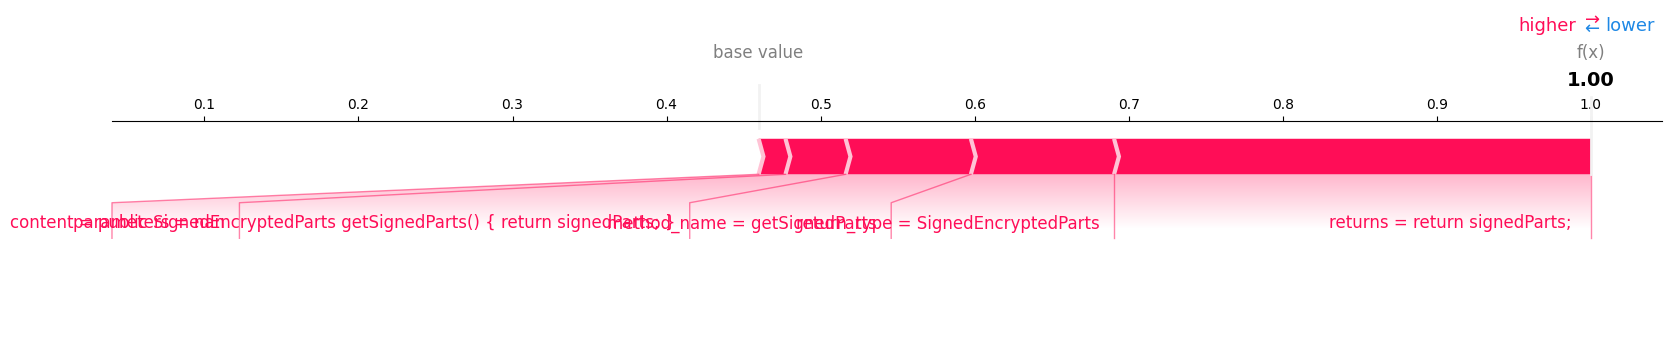



model/buildship_combined_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  0.0  0.0     1.0  0.0
1  0.0  0.0     1.0  0.0
2  0.0  0.0     1.0  0.0
3  0.0  0.0     0.0  1.0
4  1.0  0.0     0.0  0.0
the project is eclips-collections
(0, 8)
access_modifier                                               public
return_type                                                     void
method_name                                           testNestedCall
parameters                                                       NaN
returns                                                          NaN
content            { new RecursiveProcedure().value(2);  synchron...
catagory                                                          is
index                                                              1
Name: 1, dtype: object
processing train: 147083 rows x 8 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
34330  1.0  0.0     0.0  0.0
93150  0.0  0.0     0.0  1.0
6279   0.0  0.0     1.0  0.0
36576  1.0  0.

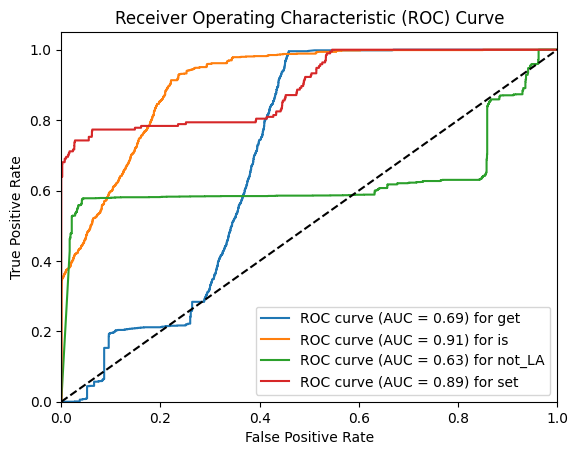

Overall AUC: 0.78174543291941
MCC for class get: 0.16696758035203177
MCC for class is: 0.3437300454754045
MCC for class not_LA: -0.4176228434578788
MCC for class set: -0.013540674678528928
Overall MCC: 0.019883526922757133
access_modifier                 static
return_type        Predicates<Integer>
method_name                     isEven
parameters                         NaN
returns               return IS_EVEN; 
content            { return IS_EVEN; }
catagory                            is
index                                2
Name: 2, dtype: object
predict output is here
['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
1  0.0  1.0     0.0  0.0
access_modifier                                               public
return_type                                                     void
method_name                                           testNestedCall
parameters                                                       NaN
returns                                                       

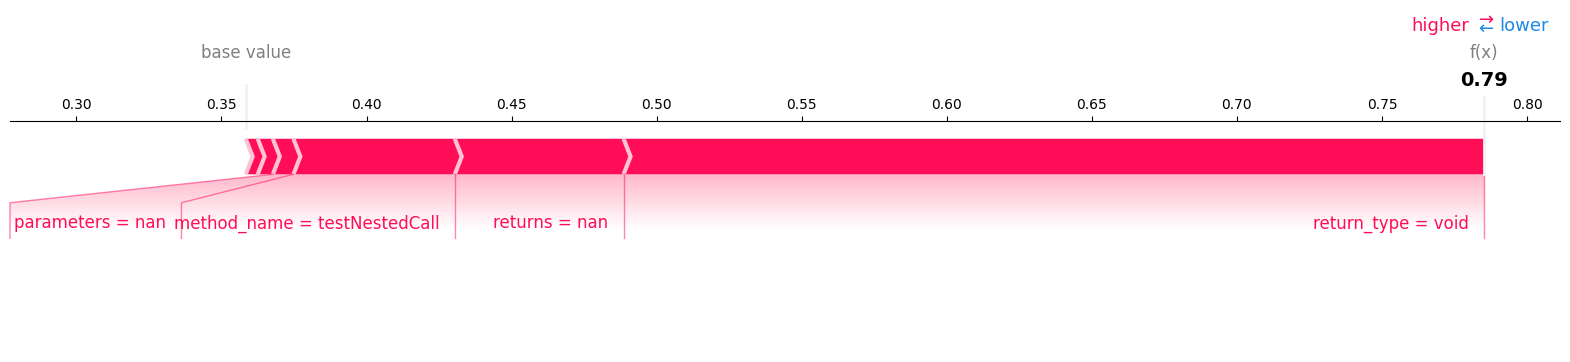



model/eclips-collections_combined_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  0.0  1.0     0.0  0.0
2  0.0  1.0     0.0  0.0
3  0.0  0.0     1.0  0.0
4  0.0  0.0     1.0  0.0
the project is jifa
(0, 8)
access_modifier                                               public
return_type                                                     void
method_name                                         getCauseInterval
parameters                                                       NaN
returns                                                          NaN
content            public double getCauseInterval() { return caus...
catagory                                                         get
index                                                              1
Name: 1, dtype: object
processing train: 150763 rows x 8 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
24201  0.0  1.0     0.0  0.0
100    0.0  0.0     1.0  0.0
8838   1.0  0.0     0.0  0.0
18842  0.0  0.0     1.0  0.0

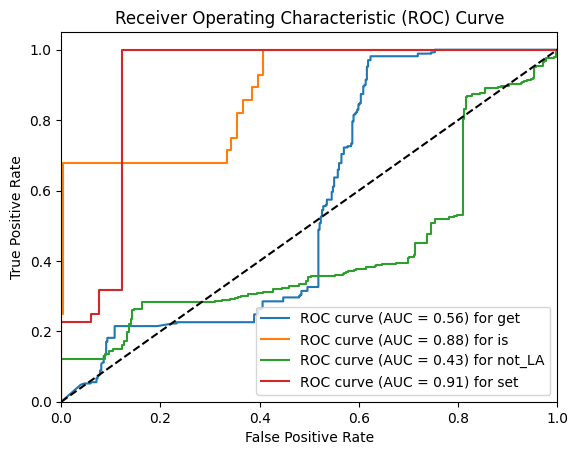

Overall AUC: 0.6934087948262749
MCC for class get: 0.1665064783040004
MCC for class is: 0.1488906960101267
MCC for class not_LA: -0.2487570051621234
MCC for class set: 0.05394489882236352
Overall MCC: 0.030146266993591797
access_modifier                                               public
return_type                                                     void
method_name                                             getObjectIds
parameters                                                       NaN
returns                                                          NaN
content            public int[] getObjectIds() { return ((IContex...
catagory                                                         get
index                                                              2
Name: 2, dtype: object
predict output is here
['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
1  1.0  0.0     0.0  0.0
access_modifier                                               public
return_type                   

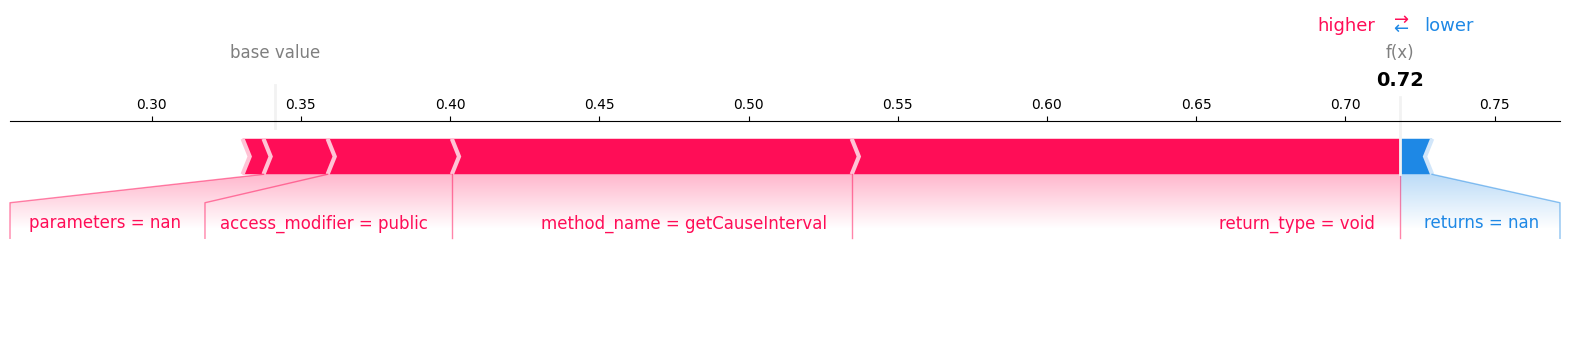



model/jifa_combined_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  1.0  0.0     0.0  0.0
2  1.0  0.0     0.0  0.0
3  1.0  0.0     0.0  0.0
4  1.0  0.0     0.0  0.0
the project is jkube
(0, 8)
access_modifier                                              private
return_type                                              ServicePort
method_name                                extractPortsFromImageSpec
parameters         String imageName, String portSpec, ServicePort...
returns            return null; return updateMissingTargetPort(po...
content            private ServicePort extractPortsFromImageSpec(...
catagory                                                      not_LA
index                                                              1
Name: 1, dtype: object
processing train: 148810 rows x 8 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
67156  0.0  1.0     0.0  0.0
7420   0.0  0.0     0.0  1.0
18113  0.0  0.0     0.0  1.0
77585  0.0  0.0     1.0  0.

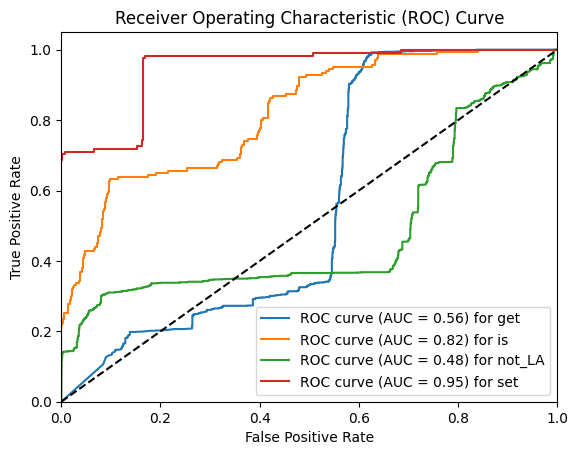

Overall AUC: 0.7010843424049709
MCC for class get: -0.22615570598063986
MCC for class is: 0.14695651991893585
MCC for class not_LA: 0.0784049950849972
MCC for class set: 0.19013867706438356
Overall MCC: 0.04733612152191918
access_modifier                                               public
return_type                                                     void
method_name                                          getDebugService
parameters                                                       NaN
returns                                                          NaN
content            public DebugService getDebugService() { return...
catagory                                                         get
index                                                              2
Name: 2, dtype: object
predict output is here
['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
1  0.0  0.0     1.0  0.0
access_modifier                                              private
return_type                  

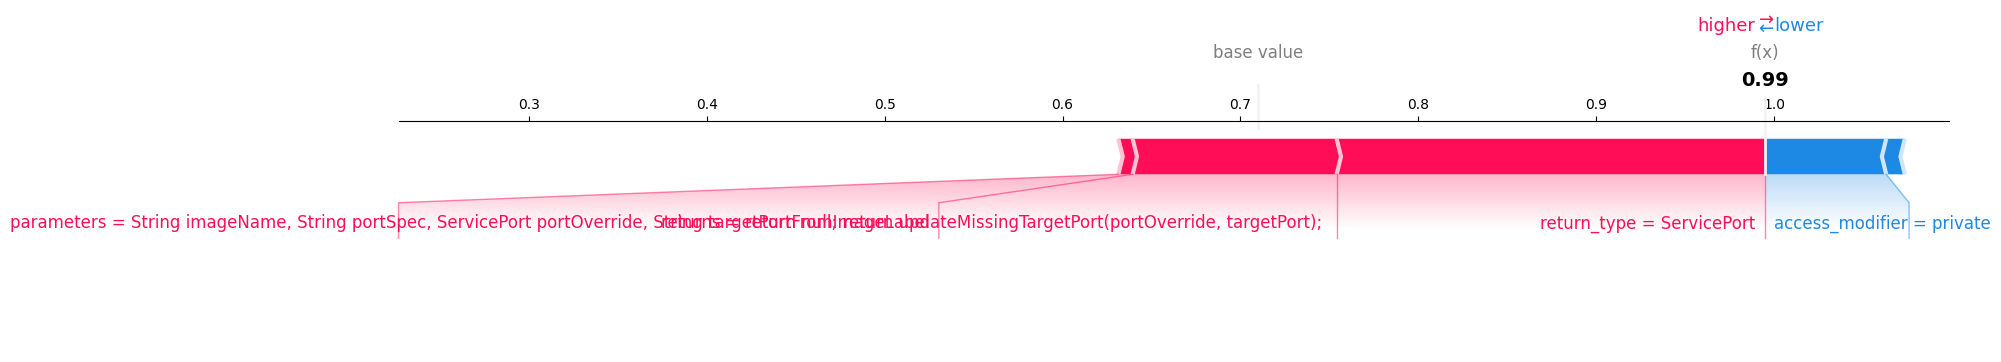



model/jkube_combined_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  0.0  0.0     1.0  0.0
1  0.0  0.0     1.0  0.0
2  1.0  0.0     0.0  0.0
3  0.0  0.0     0.0  1.0
4  1.0  0.0     0.0  0.0
the project is hawkbit
(0, 8)
access_modifier                                               public
return_type                                                     void
method_name                                        getErrorCondition
parameters                                                       NaN
returns                                                          NaN
content            public RolloutGroupErrorCondition getErrorCond...
catagory                                                         get
index                                                              1
Name: 1, dtype: object
processing train: 149003 rows x 8 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
19479  0.0  1.0     0.0  0.0
16032  0.0  1.0     0.0  0.0
42390  1.0  0.0     0.0  0.0
6209   1.0  0.0     0.0  

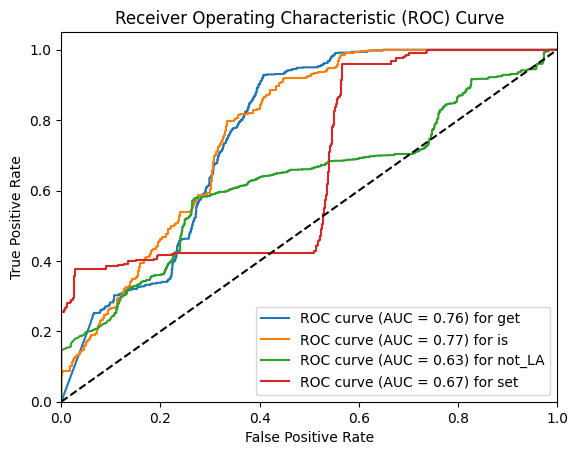

Overall AUC: 0.7087264348519344
MCC for class get: -0.23688190603293297
MCC for class is: 0.026199400560649413
MCC for class not_LA: 0.09540805637796261
MCC for class set: 0.17696738102963167
Overall MCC: 0.015423232983827678
access_modifier                         public
return_type                                int
method_name                              setId
parameters                       final Long id
returns                              return 0;
content            { this.id = id;  return 0;}
catagory                                   set
index                                        2
Name: 2, dtype: object
predict output is here
['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
1  1.0  0.0     0.0  0.0
access_modifier                                               public
return_type                                                     void
method_name                                        getErrorCondition
parameters                                                      

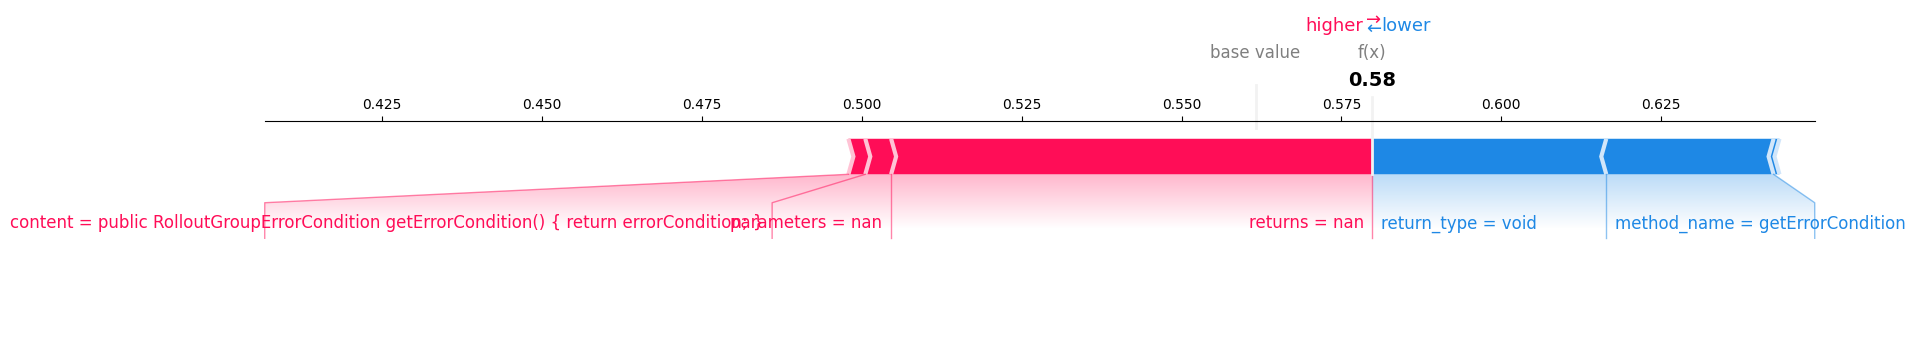



model/hawkbit_combined_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  1.0  0.0     0.0  0.0
2  0.0  0.0     0.0  1.0
3  1.0  0.0     0.0  0.0
4  0.0  1.0     0.0  0.0
the project is kura
(0, 8)
access_modifier                                               public
return_type                                         NetInterfaceType
method_name                                                  getType
parameters                                                       NaN
returns                               return NetInterfaceType.WIFI; 
content            public NetInterfaceType getType() { return Net...
catagory                                                      not_LA
index                                                              1
Name: 1, dtype: object
processing train: 132267 rows x 8 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
77157  0.0  0.0     1.0  0.0
21654  0.0  1.0     0.0  0.0
71084  0.0  0.0     1.0  0.0
9472   1.0  0.0     0.0  0.0

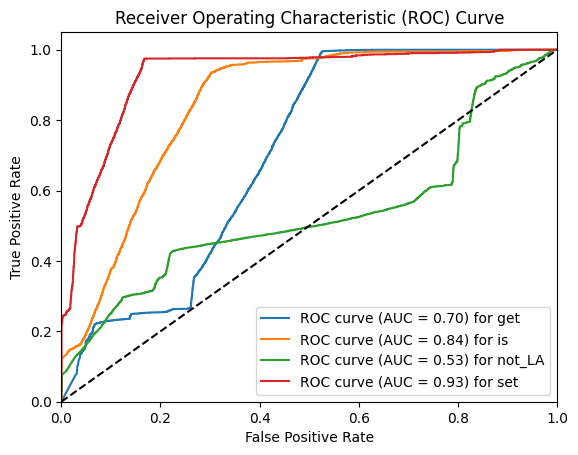

Overall AUC: 0.7519316396801445
MCC for class get: -0.22643705417044688
MCC for class is: -0.029037793283751133
MCC for class not_LA: 0.07050739867557922
MCC for class set: 0.2137890606124323
Overall MCC: 0.007205402958453372
access_modifier                                               public
return_type                                                     void
method_name                                            getFactoryPid
parameters                                                       NaN
returns                                                          NaN
content            public String getFactoryPid() { return FACTORY...
catagory                                                         get
index                                                              2
Name: 2, dtype: object
predict output is here
['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
1  0.0  0.0     1.0  0.0
access_modifier                                               public
return_type               

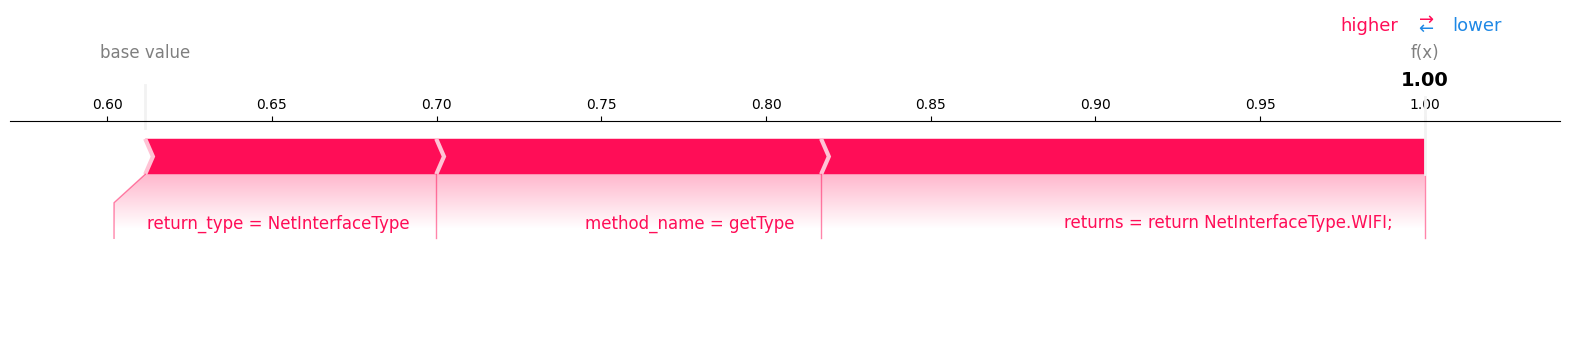



model/kura_combined_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  0.0  0.0     1.0  0.0
2  1.0  0.0     0.0  0.0
3  0.0  0.0     1.0  0.0
4  0.0  0.0     1.0  0.0
the project is milo
(0, 8)
access_modifier                                               public
return_type                                         PropertyTypeNode
method_name                                          getReqTimesNode
parameters                                                       NaN
returns                        return getReqTimesNodeAsync().get(); 
content            public PropertyTypeNode getReqTimesNode() thro...
catagory                                                      not_LA
index                                                              1
Name: 1, dtype: object
processing train: 140421 rows x 8 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
45114  0.0  0.0     1.0  0.0
93111  0.0  0.0     1.0  0.0
51200  1.0  0.0     0.0  0.0
61132  0.0  0.0     1.0  0.0

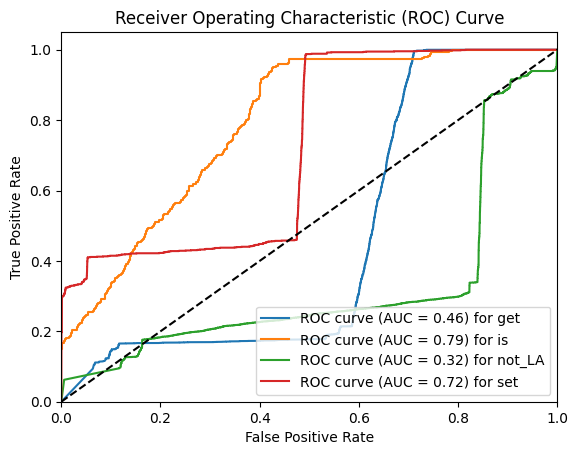

Overall AUC: 0.5725468498048294
MCC for class get: -0.1845231041455771
MCC for class is: 0.05896991170426935
MCC for class not_LA: -0.03481776172582256
MCC for class set: 0.33616478744895884
Overall MCC: 0.04394845832045713
access_modifier                                     public
return_type                                           void
method_name                                       getValue
parameters                                             NaN
returns                                                NaN
content            public int getValue() { return value; }
catagory                                               get
index                                                    2
Name: 2, dtype: object
predict output is here
['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
1  0.0  0.0     1.0  0.0
access_modifier                                               public
return_type                                         PropertyTypeNode
method_name                            

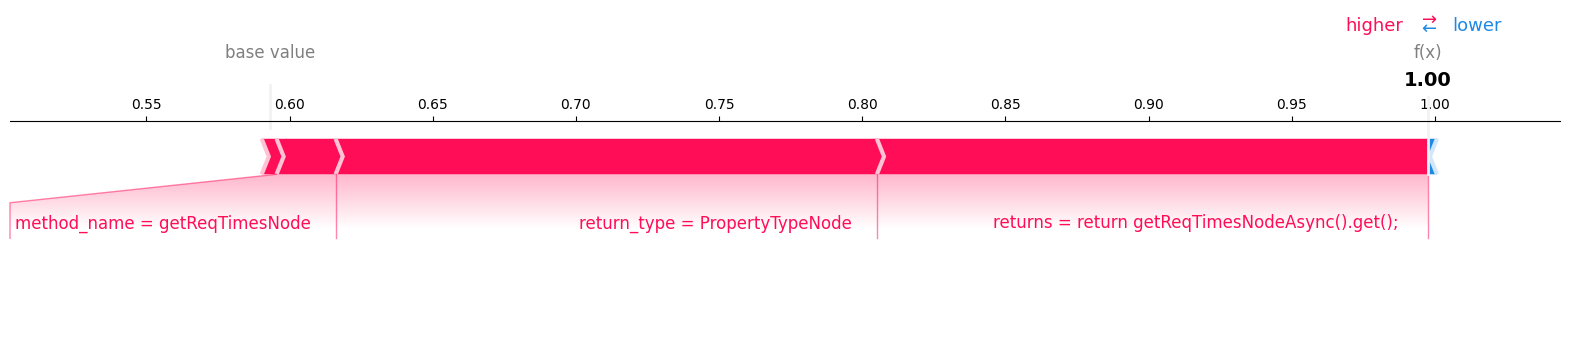



model/milo_combined_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  0.0  0.0     1.0  0.0
2  1.0  0.0     0.0  0.0
3  0.0  0.0     1.0  0.0
4  1.0  0.0     0.0  0.0
the project is openvsx
(0, 8)
access_modifier                                              private
return_type                                          AdminStatistics
method_name                                                getReport
parameters                    String tokenValue, int year, int month
returns              return admins.getAdminStatistics(year, month); 
content            private AdminStatistics getReport(String token...
catagory                                                      not_LA
index                                                              1
Name: 1, dtype: object
processing train: 149027 rows x 8 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
5530   1.0  0.0     0.0  0.0
15594  1.0  0.0     0.0  0.0
81719  0.0  0.0     1.0  0.0
5696   1.0  0.0     0.0  

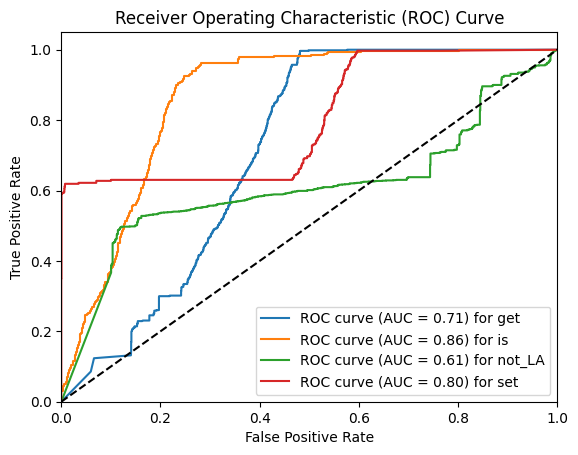

Overall AUC: 0.7460130274603509
MCC for class get: -0.18632450230690092
MCC for class is: -0.08960066065007478
MCC for class not_LA: 0.0750577930134615
MCC for class set: 0.2085725032956289
Overall MCC: 0.0019262833380286684
access_modifier                          public
return_type                                 int
method_name                setAdminStatisticsId
parameters                           Long value
returns                               return 0;
content            { set(0, value);  return 0;}
catagory                                    set
index                                         2
Name: 2, dtype: object
predict output is here
['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
1  0.0  0.0     1.0  0.0
access_modifier                                              private
return_type                                          AdminStatistics
method_name                                                getReport
parameters                    String tokenValue, int year

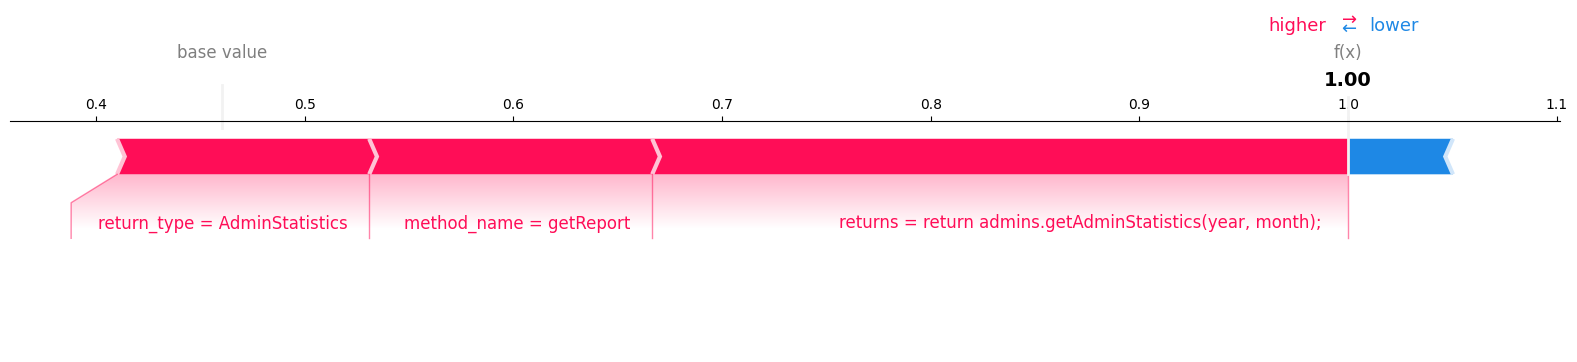



model/openvsx_combined_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  0.0  0.0     1.0  0.0
1  0.0  0.0     1.0  0.0
2  0.0  0.0     0.0  1.0
3  0.0  1.0     0.0  0.0
4  0.0  0.0     1.0  0.0
the project is steady
(0, 8)
access_modifier                                            public
return_type                                                String
method_name                                            getContext
parameters                                                    NaN
returns                                          return context; 
content            public String getContext() { return context; }
catagory                                                   not_LA
index                                                           1
Name: 1, dtype: object
processing train: 140937 rows x 8 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
12512  0.0  0.0     1.0  0.0
30283  1.0  0.0     0.0  0.0
22858  0.0  0.0     1.0  0.0
2097   0.0  0.0     1.0  0.0
10430  0.0  0.0     1

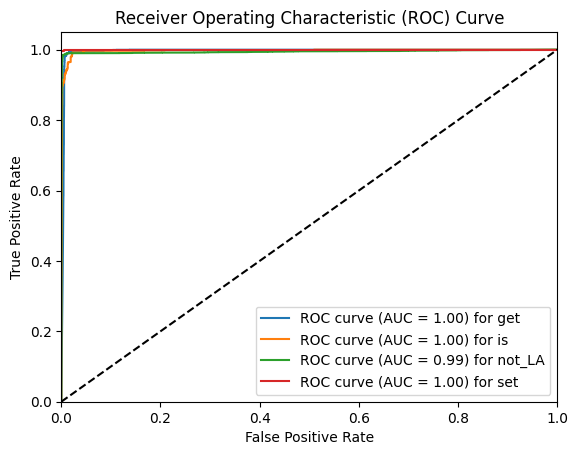

Overall AUC: 0.9969087015179823
MCC for class get: -0.4143399978312863
MCC for class is: 0.28336114349950225
MCC for class not_LA: 0.15184349062045746
MCC for class set: 0.06620504428329049
Overall MCC: 0.021767420142990983
access_modifier                                               public
return_type                                                    QName
method_name                                      getSymmetricBinding
parameters                                                       NaN
returns                                   return SYMMETRIC_BINDING; 
content            public QName getSymmetricBinding() { return SY...
catagory                                                      not_LA
index                                                              2
Name: 2, dtype: object
predict output is here
['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
1  0.0  0.0     1.0  0.0
access_modifier                                            public
return_type                    

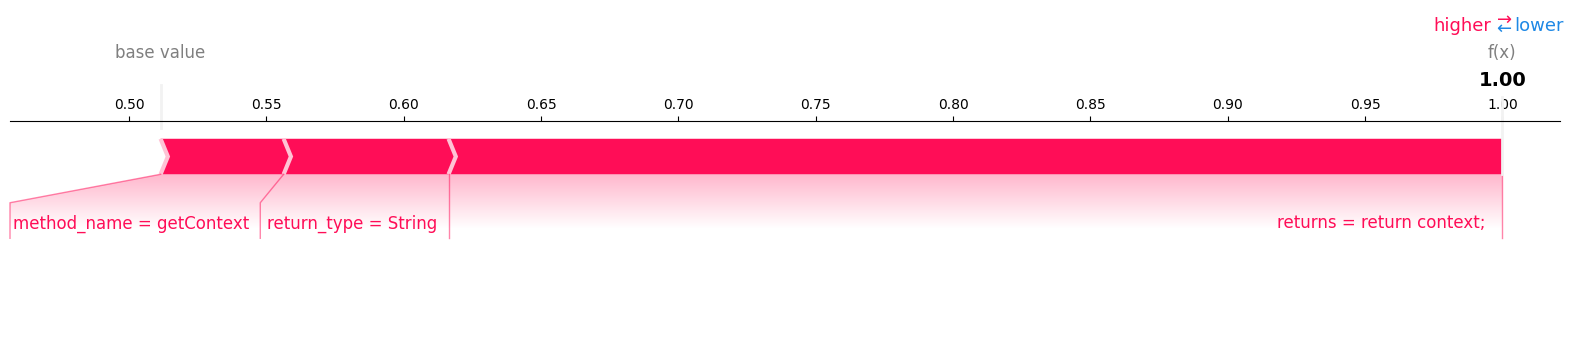



model/steady_combined_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  0.0  0.0     1.0  0.0
1  0.0  0.0     1.0  0.0
2  0.0  0.0     1.0  0.0
3  0.0  0.0     0.0  1.0
4  0.0  0.0     1.0  0.0
the project is xtext
(0, 8)
access_modifier                                               public
return_type                                                     void
method_name                                          testRuleCall_01
parameters                                                       NaN
returns                                                          NaN
content            @Test public void testRuleCall_01() throws Exc...
catagory                                                          is
index                                                              1
Name: 1, dtype: object
processing train: 62026 rows x 8 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
9078   1.0  0.0     0.0  0.0
6208   0.0  1.0     0.0  0.0
1311   0.0  0.0     1.0  0.0
20792  1.0  0.0     0.0  0.0

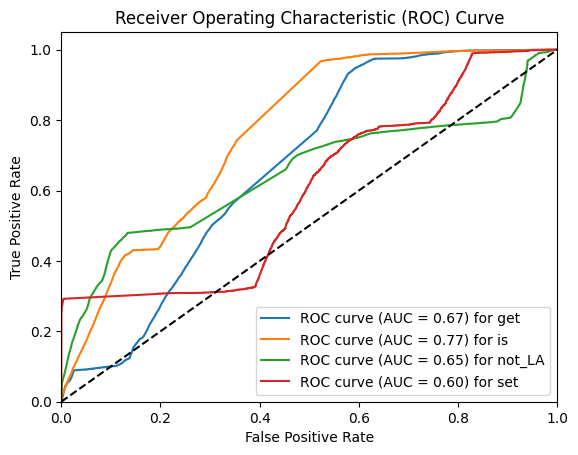

Overall AUC: 0.6706740827803376
MCC for class get: 0.08868067662602828
MCC for class is: 0.1999122773296492
MCC for class not_LA: -0.22847735620294826
MCC for class set: -0.00999302844862839
Overall MCC: 0.012530642326025203
access_modifier                                               public
return_type                                                     void
method_name                                            setEcoreModel
parameters                                         String ecoreModel
returns                                                          NaN
content            public void setEcoreModel(String ecoreModel) {...
catagory                                                      not_LA
index                                                              2
Name: 2, dtype: object
predict output is here
['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
1  0.0  1.0     0.0  0.0
access_modifier                                               public
return_type                

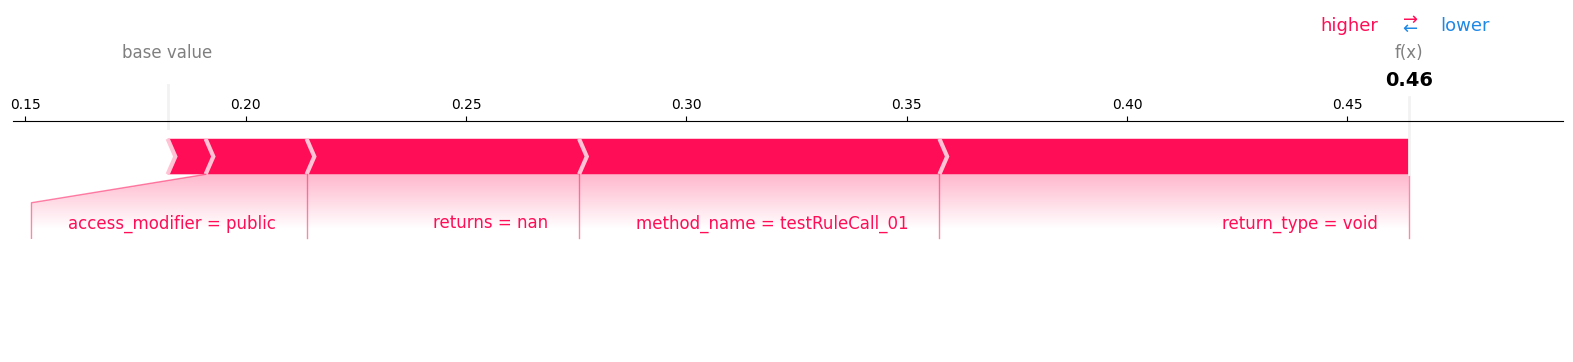



model/xtext_combined_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  0.0  1.0     0.0  0.0
1  0.0  1.0     0.0  0.0
2  0.0  0.0     1.0  0.0
3  1.0  0.0     0.0  0.0
4  0.0  0.0     1.0  0.0


In [17]:
a = {
    "buildship": " ", 
    "eclips-collections": " ",
    "jifa": " ",
    "jkube": " ",
    "hawkbit": "https://github.com/eclipse/hawkbit.git",
    "kura": "https://github.com/eclipse/kura.git",
    "milo": "https://github.com/eclipse/milo.git",
    "openvsx": "https://github.com/eclipse/openvsx.git",
    "steady": "https://github.com/eclipse/steady.git",
    "xtext": "https://github.com/eclipse/xtext.git"
}
for project,url in a.items():
    print(f"the project is {project}")
    train_df,test_df = get_model(a,project)
    predictor = get_lean(train_df,test_df)
    model_save(predictor,test_df,project)